In [30]:
!pip install kneed


In [43]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
data = pd.read_excel('/Users/miked/Documents/Kmeans Practice/online_retail_II.xlsx')

In [33]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


Take notice of each column and plug them into the function: 

'Invoice' 'StockCode' 'Description' 'Quantity' 'InvoiceDate' 'Price' 'Customer ID' 'Country'

In [39]:
def preprocess_data(data_path):
    """
    Load the data, calculate the Monetary value, and compute RFM metrics.
    
    Parameters:
    - data_path: Path to the dataset
    
    Returns:
    - rfm: DataFrame with RFM metrics for each customer
    """
    # Load the dataset
    data = pd.read_excel(data_path)
    
    # Calculate the Monetary value for each transaction
    data['Monetary'] = data['Quantity'] * data['Price']

    # Calculate the most recent purchase date for RFM analysis
    latest_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)

    # Group by Customer ID and calculate RFM metrics
    rfm = data.groupby('Customer ID').agg({
        'InvoiceDate': lambda x: (latest_date - x.max()).days,  # Recency
        'Invoice': 'nunique',  # Frequency
        'Monetary': 'sum'  # Monetary Value
    })

    # Rename the columns
    rfm.rename(columns={
        'InvoiceDate': 'Recency',
        'Invoice': 'Frequency',
        'Monetary': 'MonetaryValue'
    }, inplace=True)
    
    return rfm

def scale_data(rfm):
    """
    Scale the RFM data.
    
    Parameters:
    - rfm: DataFrame with RFM metrics
    
    Returns:
    - rfm_scaled: Scaled RFM data
    """
    scaler = StandardScaler()
    rfm_scaled = scaler.fit_transform(rfm)
    return rfm_scaled

def determine_optimal_clusters(rfm_scaled, max_clusters=15):
    """
    Determine the optimal number of clusters using the elbow method.
    
    Parameters:
    - rfm_scaled: Scaled RFM data
    - max_clusters: Maximum number of clusters to test
    
    Returns:
    - wcss: List of WCSS values for each number of clusters
    """
    wcss = []
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
        kmeans.fit(rfm_scaled)
        wcss.append(kmeans.inertia_)
    return wcss

def perform_clustering(rfm_scaled, n_clusters):
    """
    Apply K-Means clustering on the data.
    
    Parameters:
    - rfm_scaled: Scaled RFM data
    - n_clusters: Number of clusters
    
    Returns:
    - clusters: Cluster labels for the data
    """
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42)
    clusters = kmeans.fit_predict(rfm_scaled)
    return clusters

In [40]:
# import the data
rfm_data = preprocess_data('/Users/miked/Documents/Kmeans Practice/online_retail_II.xlsx')


In [41]:
# Scale the data
rfm_scaled = scale_data(rfm_data)

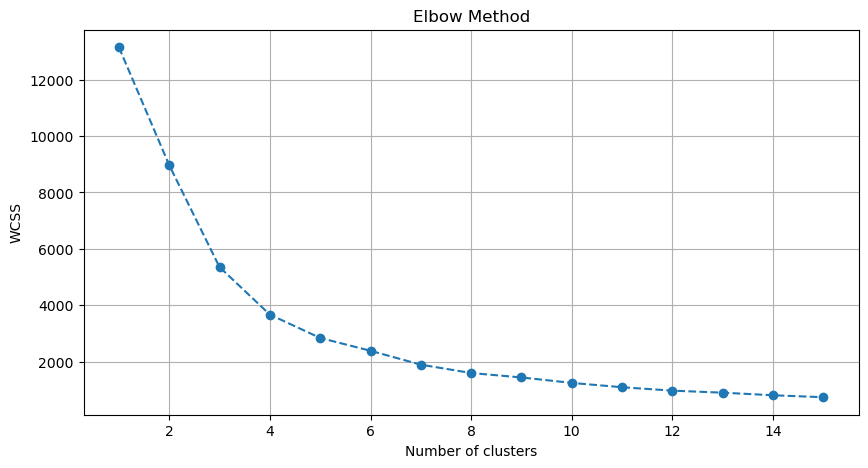

In [42]:
wcss_values = determine_optimal_clusters(rfm_scaled, max_clusters=15)

# Plotting the WCSS values to determine the elbow point
plt.figure(figsize=(10, 5))
plt.plot(range(1, 16), wcss_values, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()


  Cluster     Recency              Frequency             MonetaryValue  \
                 mean        std        mean        std           mean   
0       0   42.195445  35.025602    5.425362   5.267890    1658.413782   
1       1    5.600000   4.335897  139.000000  75.759488  206931.732000   
2       2  244.559070  66.524348    1.903256   1.580826     407.135641   
3       3   10.425926  21.612891   59.611111  35.261512   27549.865241   

                 
            std  
0   2367.807941  
1  88189.956858  
2   1512.017269  
3  18411.447210  


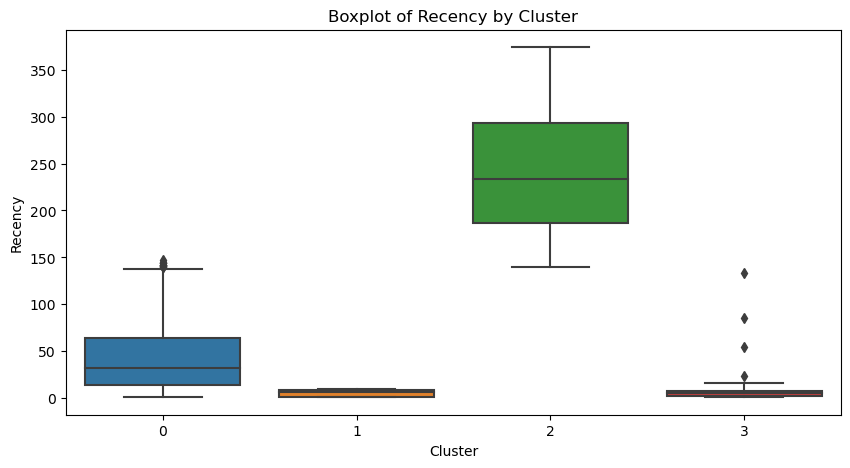

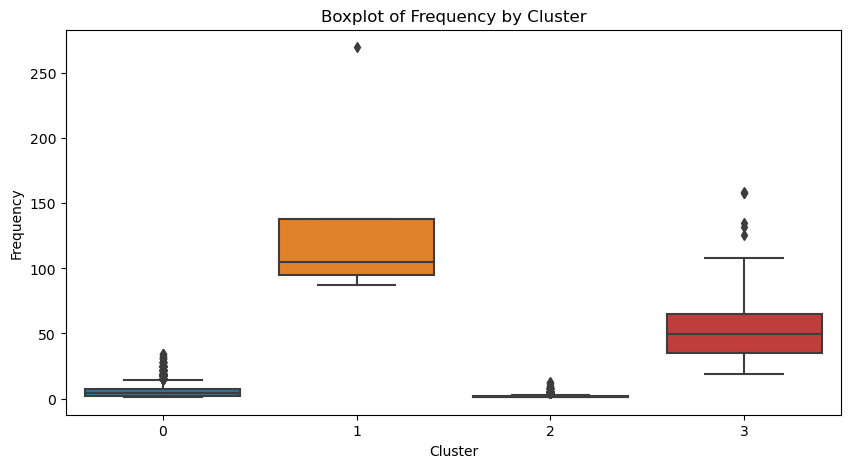

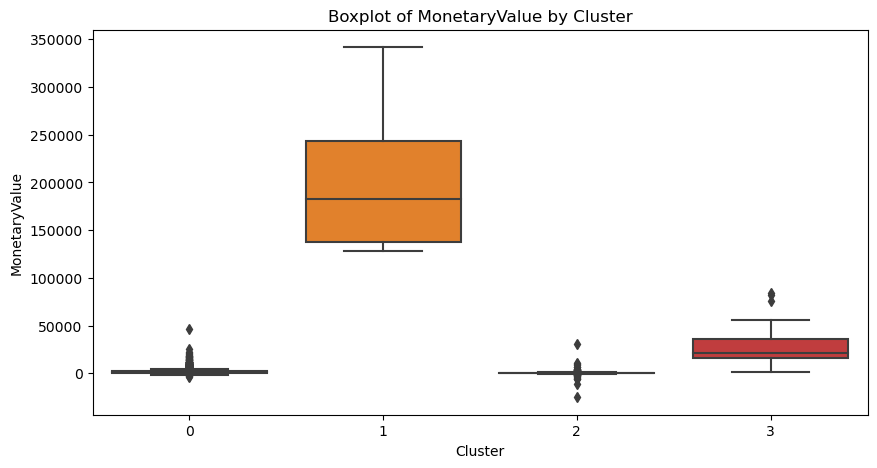

Silhouette Score: 0.61


In [44]:
# 1. Automate the Elbow Point Detection
def find_elbow_point(wcss_values):
    """
    Determine the elbow point in the WCSS curve.
    
    Parameters:
    - wcss_values: List of WCSS values
    
    Returns:
    - elbow_point: Optimal number of clusters determined by the elbow point
    """
    x = range(1, len(wcss_values) + 1)
    y = wcss_values
    kn = KneeLocator(x, y, curve='convex', direction='decreasing')
    return kn.elbow

optimal_clusters = find_elbow_point(wcss_values)

# 2. Perform the Clustering
clusters = perform_clustering(rfm_scaled, optimal_clusters)

# Append clusters to original data
rfm_data['Cluster'] = clusters

# 3. Analyze the Clusters
cluster_summary = rfm_data.groupby('Cluster').agg({
    'Recency': ['mean', 'std'],
    'Frequency': ['mean', 'std'],
    'MonetaryValue': ['mean', 'std']
}).reset_index()

print(cluster_summary)

# 4. Visualize the Clusters (just a simple example, you can expand on this)
for column in rfm_data.columns[:-1]:  # Exclude 'Cluster' column
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=rfm_data, x='Cluster', y=column)
    plt.title(f'Boxplot of {column} by Cluster')
    plt.show()

# 5. Evaluate the Clustering
silhouette_avg = silhouette_score(rfm_scaled, clusters)
print(f"Silhouette Score: {silhouette_avg:.2f}")

- 0.71−1.0: A strong structure has been found.
- 0.51−0.70: A reasonable structure has been found.
- 0.26−0.50: The structure is weak and could be artificial.
- ≤0.25: No substantial structure has been found.

Explore the data and create labels that make sense for the clusters

In [45]:
# Naming the clusters based on behavior
cluster_names = {
    0: "Regular Shoppers",
    1: "Top VIP Customers",
    2: "Inactive Low-Spenders",
    3: "Loyal High-Spenders"
}

rfm_data['ClusterName'] = rfm_data['Cluster'].map(cluster_names)

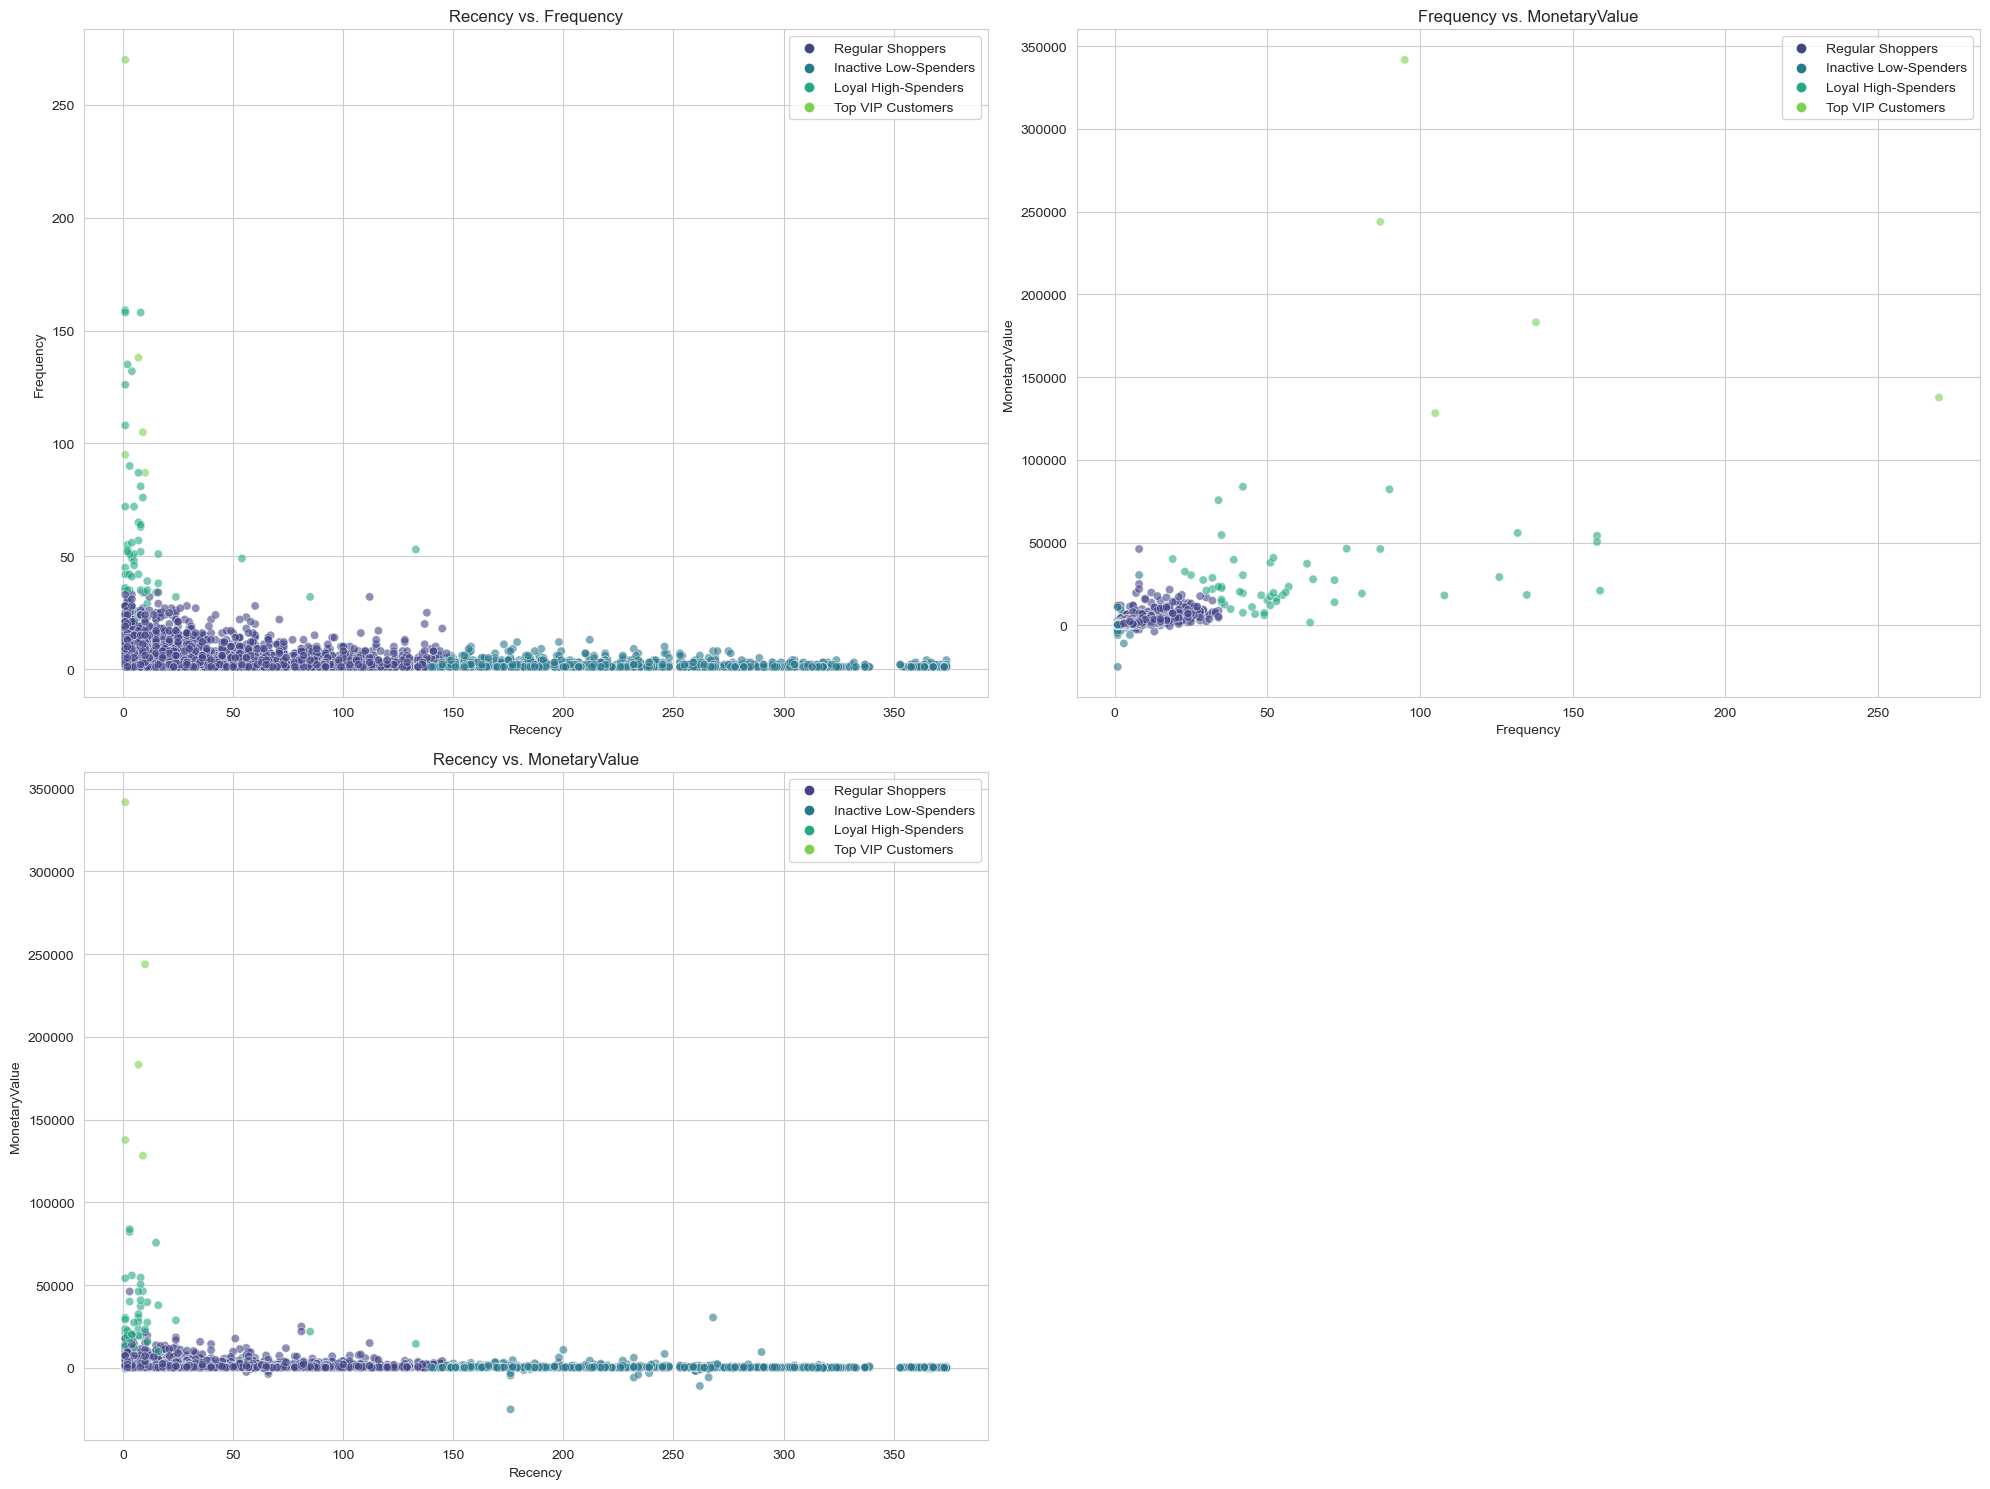

In [47]:
# Set style and figure size
sns.set_style("whitegrid")
plt.figure(figsize=(20, 15))

# Scatter plot for Recency vs. Frequency
plt.subplot(2, 2, 1)
sns.scatterplot(data=rfm_data, x='Recency', y='Frequency', hue='ClusterName', palette='viridis', alpha=0.6)
plt.title('Recency vs. Frequency')
plt.legend(loc='upper right')

# Scatter plot for Frequency vs. MonetaryValue
plt.subplot(2, 2, 2)
sns.scatterplot(data=rfm_data, x='Frequency', y='MonetaryValue', hue='ClusterName', palette='viridis', alpha=0.6)
plt.title('Frequency vs. MonetaryValue')
plt.legend(loc='upper right')

# Scatter plot for Recency vs. MonetaryValue
plt.subplot(2, 2, 3)
sns.scatterplot(data=rfm_data, x='Recency', y='MonetaryValue', hue='ClusterName', palette='viridis', alpha=0.6)
plt.title('Recency vs. MonetaryValue')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [51]:
# Calculate average RFM values for each cluster
cluster_avg = rfm_data.groupby('Cluster').mean(numeric_only=True)

cluster_avg

,Recency,Frequency,MonetaryValue
Cluster,,,
0,42.195445,5.425362,1658.413782
1,5.600000,139.000000,206931.732000
2,244.559070,1.903256,407.135641
3,10.425926,59.611111,27549.865241


1. Recency vs. Frequency:
- The "Inactive Low-Spenders" cluster (in green) generally has high recency, indicating they haven't made purchases in a long time.
- "Regular Shoppers" (in blue) and "Loyal High-Spenders" (in purple) have lower recency, implying more recent interactions with the business.
- "Top VIP Customers" (in orange) are closer to the origin, showcasing their very recent and frequent interactions.
2. Frequency vs. MonetaryValue:
- The "Top VIP Customers" cluster stands out with high frequency and very high monetary value.
- "Loyal High-Spenders" exhibit a higher frequency and monetary spend compared to "Regular Shoppers".
- "Inactive Low-Spenders" typically have low frequency and monetary value.
3. Recency vs. MonetaryValue:
- "Top VIP Customers" have both recent interactions and high monetary spend.
- "Regular Shoppers" have a spread across recency but generally lower monetary values.
- "Inactive Low-Spenders" tend to have both high recency and lower monetary values.

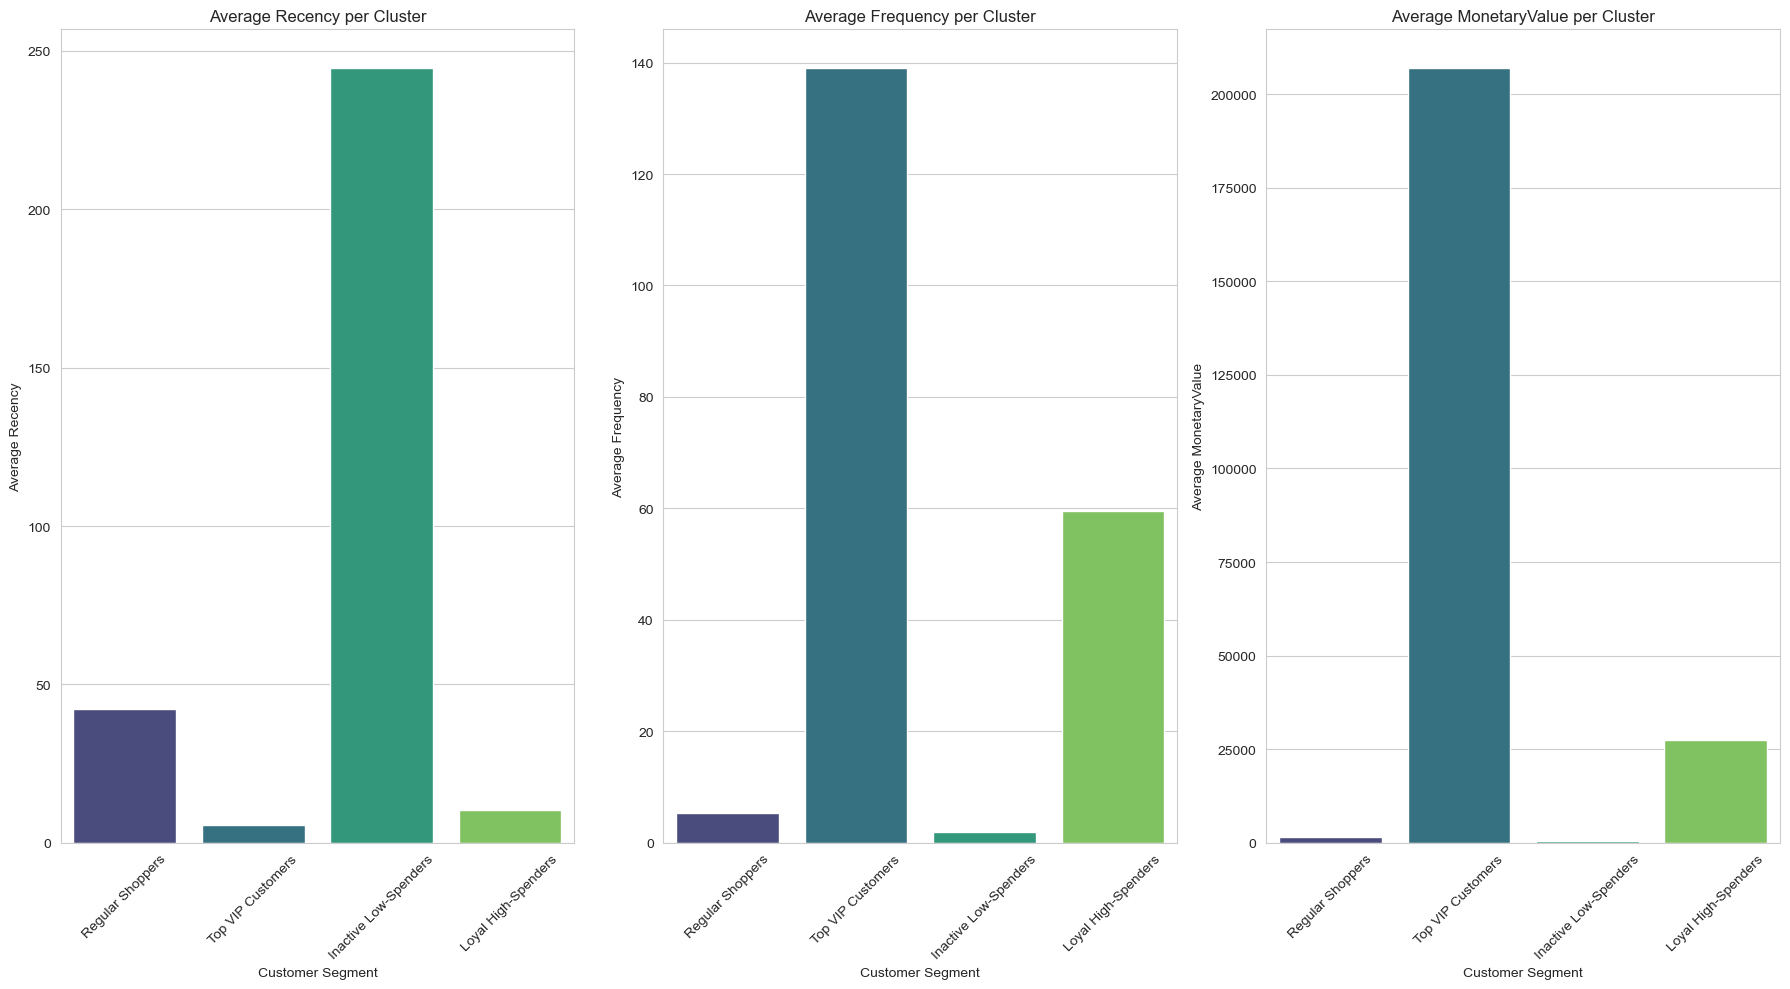

In [52]:
# Bar charts for average RFM values per cluster

plt.figure(figsize=(18, 10))

# Bar chart for Average Recency
plt.subplot(1, 3, 1)
sns.barplot(x=cluster_avg.index.map(cluster_names), y=cluster_avg['Recency'], palette="viridis")
plt.title('Average Recency per Cluster')
plt.ylabel('Average Recency')
plt.xlabel('Customer Segment')
plt.xticks(rotation=45)

# Bar chart for Average Frequency
plt.subplot(1, 3, 2)
sns.barplot(x=cluster_avg.index.map(cluster_names), y=cluster_avg['Frequency'], palette="viridis")
plt.title('Average Frequency per Cluster')
plt.ylabel('Average Frequency')
plt.xlabel('Customer Segment')
plt.xticks(rotation=45)

# Bar chart for Average MonetaryValue
plt.subplot(1, 3, 3)
sns.barplot(x=cluster_avg.index.map(cluster_names), y=cluster_avg['MonetaryValue'], palette="viridis")
plt.title('Average MonetaryValue per Cluster')
plt.ylabel('Average MonetaryValue')
plt.xlabel('Customer Segment')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

1. Average Recency for Customer Segment:
- Inactive Low-Spenders have the highest average recency, indicating they haven't interacted with the business in a while.
- Top VIP Customers and Loyal High-Spenders have lower recency, indicating their recent interactions with the business.
- Regular Shoppers have a moderate level of recency.
2. Average Frequency per Customer Segment:
- Top VIP Customers have the highest average frequency, showcasing their frequent interactions and purchases.
- Loyal High-Spenders also have a high frequency, indicating their consistent purchasing behavior.
- Regular Shoppers have a moderate level of frequency.
- Inactive Low-Spenders have the lowest frequency, in line with their profile of limited interactions.
3. Average Monetary Value per Customer Segment:
- Top VIP Customers clearly stand out with an exceptionally high average monetary value, underscoring their significant contribution to the business's revenue.
- Loyal High-Spenders also contribute a high monetary value, reflecting their consistent and high-value purchasing behavior.
- Regular Shoppers contribute a moderate monetary value.
- Inactive Low-Spenders have the lowest monetary value, consistent with their limited interactions and spending.